# Project 7 

In this project, you will implement the the clustering techniques that you've learned this week. 

#### Step 1: Load the python libraries that you will need for this project 

In [39]:
import pandas as pd 
import matplotlib as plt
import numpy as np
import sklearn
import psycopg2 as psy
import csv
from sqlalchemy import create_engine
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
%matplotlib inline
from sklearn.decomposition import PCA 
import pandas as pd
from pandas.io import sql
import pandas as pd
import numpy as np
%matplotlib inline
from sklearn.feature_extraction.text import CountVectorizer

import matplotlib.pyplot as plt


#### Step 2: Examine your data 

In [40]:
cancel = pd.read_csv("/Users/EKandTower/GA-DSI/projects/projects-weekly/project-07/\
assets/airport_cancellations.csv")

ops = pd.read_csv("/Users/EKandTower/GA-DSI/projects/projects-weekly/project-07/\
assets/Airport_operations.csv")

ap = pd.read_csv("/Users/EKandTower/GA-DSI/projects/projects-weekly/project-07/\
assets/airports.csv")

# ajbentley

# EKandTower


### Intro: Write a problem statement / aim for this project

Objective: Your task is to understand the distribution, characteristics, and components of individual airports operations that are leading to these delays.


First step is to identify which airports are the "problem children." We can do this with PCA and clustering.

Will run naive PCA and pare down on features to reduce overfitting until we can get at least 70% explained on 3 features. Then we'll use those features to cluster.

Clustering on PCAs should show what airports have higher than normal delay times and whose operations have been flat or worsening.

Once we ID what airports are the problems we can figure out what they have in common. 

Once they have been identified we can do classification to find out what the specific metrics are that are impacting their efficiancy. 

### Part 1: Create a PostgreSQL database 

#### 1. Let's create a database where we can house our airport data

In [41]:
# import sqlite3
# sqlite_db = 'dsi2-db.sqlite'
# conn = sqlite3.connect(sqlite_db)
# c = conn.cursor()

# print "done"

In [42]:
# con = None
# con = psy.connect(database='Default', user='postgres') 

In [43]:
# engine = create_engine('postgresql://localhost:5432/apdb')
# cancel.to_sql('cancel', engine, if_exists='replace')
# operations.to_sql('ops', engine, if_exists='replace')
# apdb.to_sql('apdb', engine, if_exists='replace')
# %load_ext sql


Load our csv files into tables

Join airport_cancellations.csv and airports.csv into one table

In [44]:
cancel.rename(columns ={'Airport':'AP_NAME'}, inplace=True)

In [45]:
df = cancel.join(ap, rsuffix='ap')
df.pop('AP_NAMEap');

In [46]:
df = df.join(ops, rsuffix='ops')


Query the database for our intial data

#### 1.2 What are the risks and assumptions of our data? 

While there is considerable information presented there is a massive amount of information that feels like it most be colinear (several flavors of delays and arrivals, all of which probably correlate highly).

There's also data that are missing. It would be significant to see meteorological data, which I have to imagine the FAA collects, to show whether temperature and precipitation have seen significant shifts in this time.

It could be useful to see whether there is any difference in monthly numbers. Has tourism increased?

Once we get down to the individual airports that we need to consider it would be good to see whether there have been changes in the airlines serving the airport or in the sources / destinations of the planes. If flights from Denver tend to be late and they've just started a new direct flight from Denver to DC then the delays in DC would change.

### Part 2: Exploratory Data Analysis

#### 2.1 Plot and Describe the Data

In [47]:
df.describe()

,Year,Departure Cancellations,Arrival Cancellations,Departure Diversions,Arrival Diversions,Key,Latitude,Longitude,year,departures for metric computation,...,percent on-time airport departures,percent on-time gate arrivals,average_gate_departure_delay,average_taxi_out_time,average taxi out delay,average airport departure delay,average airborne delay,average taxi in delay,average block delay,average gate arrival delay
count,805.000000,805.000000,805.000000,805.000000,805.000000,805.000000,805.000000,805.000000,805.000000,805.000000,...,805.000000,805.000000,805.000000,805.000000,805.000000,805.000000,805.000000,805.000000,805.000000,805.000000
mean,2008.986335,1292.038509,1333.124224,173.315528,169.413665,2488.650932,30.522748,-93.577507,2009.014907,111331.108075,...,0.719039,0.760144,13.299888,13.813453,3.604907,16.059615,2.930112,1.385006,3.322807,13.743565
std,3.158116,1835.961943,1975.224868,172.345539,228.521615,1607.433809,2.806227,12.880292,3.152394,99041.431112,...,0.088554,0.068339,4.076106,3.836060,2.397139,4.937230,1.199621,0.879909,1.029183,3.907379
min,2004.000000,0.000000,0.000000,0.000000,0.000000,254.000000,17.701556,-177.381308,2004.000000,261.000000,...,0.245700,0.349500,5.350000,7.040000,0.000000,6.290000,0.950000,0.000000,1.230000,6.330000
25%,2006.000000,349.000000,314.000000,62.000000,41.000000,880.000000,29.607333,-97.969472,2006.000000,39279.000000,...,0.686300,0.738100,10.950000,11.330000,2.230000,12.980000,2.060000,0.820000,2.630000,11.270000
50%,2009.000000,663.000000,642.000000,110.000000,84.000000,2900.000000,31.179278,-93.745023,2009.000000,73741.000000,...,0.736200,0.769300,12.670000,12.930000,3.030000,15.240000,2.660000,1.120000,3.150000,13.070000
75%,2012.000000,1472.000000,1523.000000,236.000000,190.000000,3319.000000,32.493417,-84.557425,2012.000000,166455.000000,...,0.770700,0.797500,14.820000,15.720000,4.190000,17.850000,3.620000,1.770000,3.850000,15.190000
max,2014.000000,16618.000000,17571.000000,1064.000000,1948.000000,5251.000000,33.303458,-64.801722,2014.000000,491826.000000,...,0.897400,0.880300,40.800000,35.760000,18.940000,40.870000,7.820000,6.180000,7.520000,34.280000


In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 805 entries, 0 to 804
Data columns (total 33 columns):
AP_NAME                               805 non-null object
Year                                  805 non-null float64
Departure Cancellations               805 non-null float64
Arrival Cancellations                 805 non-null float64
Departure Diversions                  805 non-null float64
Arrival Diversions                    805 non-null float64
Key                                   805 non-null float64
LocID                                 804 non-null object
ALIAS                                 631 non-null object
Facility Type                         805 non-null object
FAA REGION                            805 non-null object
COUNTY                                805 non-null object
CITY                                  805 non-null object
STATE                                 805 non-null object
AP Type                               805 non-null object
Latitude           

In [49]:

# df['AP_NAME'] = LabelEncoder().fit_transform(df['AP_NAME'])
df['FAA REGION'] = LabelEncoder().fit_transform(df['FAA REGION'])
df['LocID'] = LabelEncoder().fit_transform(df['LocID'])

df['ALIAS'] = LabelEncoder().fit_transform(df['ALIAS'])
df['Facility Type'] = LabelEncoder().fit_transform(df['Facility Type'])
df['COUNTY'] = LabelEncoder().fit_transform(df['COUNTY'])
df['CITY'] = LabelEncoder().fit_transform(df['CITY'])
df['STATE'] = LabelEncoder().fit_transform(df['STATE'])
df['AP Type'] = LabelEncoder().fit_transform(df['AP Type'])
df['Boundary Data Available'] = LabelEncoder().fit_transform(df['Boundary Data Available'])
df['airport'] = LabelEncoder().fit_transform(df['airport'])




In [50]:
# making new db with only 2014 data. As indicated at the head of this document, my preferred analysis on this would\
# to just use 2014 and the change metrics. I think prior years' data are useful mostly for the change.

df14 = pd.DataFrame(df.loc[df['Year'] == 2014])
df14.head()

,AP_NAME,Year,Departure Cancellations,Arrival Cancellations,Departure Diversions,Arrival Diversions,Key,LocID,ALIAS,Facility Type,...,percent on-time airport departures,percent on-time gate arrivals,average_gate_departure_delay,average_taxi_out_time,average taxi out delay,average airport departure delay,average airborne delay,average taxi in delay,average block delay,average gate arrival delay
10,ABQ,2014.0,315.0,274.0,66.0,37.0,2885.0,677,11,0,...,0.7148,0.7320,14.30,10.64,2.41,15.99,1.73,1.02,2.40,14.72
21,ANC,2014.0,111.0,162.0,74.0,28.0,982.0,570,421,0,...,0.8074,0.8600,11.33,11.33,1.33,12.34,4.09,0.54,4.57,10.82
32,ATL,2014.0,5977.0,6483.0,781.0,655.0,4196.0,788,0,0,...,0.7134,0.8123,11.99,17.40,4.92,15.93,2.74,2.77,3.21,12.42
43,AUS,2014.0,484.0,435.0,88.0,97.0,3282.0,628,482,0,...,0.7382,0.7222,14.16,11.76,2.06,15.59,2.25,1.08,2.88,16.20
54,BDL,2014.0,467.0,421.0,57.0,32.0,5145.0,693,0,0,...,0.7605,0.7569,12.64,12.76,2.58,14.39,2.34,0.95,2.64,14.79


In [51]:
# sns.pairplot(df14, kind="scatter", size=10)

#### Are there any unique values? 

They're almost all unique values.'

### Part 3: Data Mining

#### 3.1 Create Dummy Variables

In [52]:
# region_dummy = pd.get_dummies(df['FAA REGION'], prefix='Region')

# df = df.join(region_dummy)

# df.head()

# cv = CountVectorizer()
# data = cv.fit_transform(df.Genre).todense()
# columns = ['genre_'+c for c in cv.get_feature_names()]

# df['airport'] = LabelEncoder().fit_transform(df['airport'])
# df['airport'] = MinMaxScaler().fit_transform(df['airport'].astype(float).reshape(-1, 1))


# df.pop('ALIAS')
# df.pop('COUNTY')
# df.pop('CITY')
# df.pop('STATE')
# df.pop('Boundary Data Available')
# df.pop('year')
# df.pop('airport');
# df14.pop('ap_type')
# df14.pop('region')
# df14.pop('LocID')

#### 3.2 Format and Clean the Data

In [53]:
# df.pop('Key');

In [54]:
# df.pop('ALIAS')
# df.pop('COUNTY')
# df.pop('CITY')
# df.pop('STATE')
# df.pop('Boundary Data Available')
# df.pop('year')
# df.pop('airport');

In [55]:
# df14.columns = ['airport','year','DCancel','ACancel','DDivert','ADivert','LocID','region','ap_type','Lat','Long','deps'\
#               ,'arr','pct_ont_gateD','pct_ont_airptD','pct_ont_gateA','avg_gate_Ddelay','avg_taxi_out',\
#               'avg_taxi_delay','avg_airptDdelay','avg_airborne_delay','avg_taxi_in_delay','avg_block_delay',\
#               'avg_gate_Adelay','Region_ASO','Region_ASW','Region_AWP']
# df14.head()

In [56]:
df14.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72 entries, 10 to 804
Data columns (total 33 columns):
AP_NAME                               72 non-null object
Year                                  72 non-null float64
Departure Cancellations               72 non-null float64
Arrival Cancellations                 72 non-null float64
Departure Diversions                  72 non-null float64
Arrival Diversions                    72 non-null float64
Key                                   72 non-null float64
LocID                                 72 non-null int64
ALIAS                                 72 non-null int64
Facility Type                         72 non-null int64
FAA REGION                            72 non-null int64
COUNTY                                72 non-null int64
CITY                                  72 non-null int64
STATE                                 72 non-null int64
AP Type                               72 non-null int64
Latitude                              72 n

In [57]:
# create more manageable list for visualizations 


dfn = ['Departure Cancellations','Arrival Cancellations','Departure Diversions','Arrival Diversions','Latitude'\
       ,'Longitude','departures for metric computation','arrivals for metric computation',\
       'percent on-time gate departures', 'percent on-time airport departures','percent on-time gate arrivals',\
       'average_taxi_out_time','average taxi out delay','average airport departure delay','average airborne delay',\
       'average taxi in delay','average block delay','average gate arrival delay' ]
dfn = pd.DataFrame(df14[dfn])
dfn.head()


,Departure Cancellations,Arrival Cancellations,Departure Diversions,Arrival Diversions,Latitude,Longitude,departures for metric computation,arrivals for metric computation,percent on-time gate departures,percent on-time airport departures,percent on-time gate arrivals,average_taxi_out_time,average taxi out delay,average airport departure delay,average airborne delay,average taxi in delay,average block delay,average gate arrival delay
10,315.0,274.0,66.0,37.0,18.439295,-66.002004,33292,33137,0.7451,0.7148,0.7320,10.64,2.41,15.99,1.73,1.02,2.40,14.72
21,111.0,162.0,74.0,28.0,21.152886,-157.096256,71099,66704,0.8288,0.8074,0.8600,11.33,1.33,12.34,4.09,0.54,4.57,10.82
32,5977.0,6483.0,781.0,655.0,25.778333,-80.170278,428954,428312,0.7899,0.7134,0.8123,17.40,4.92,15.93,2.74,2.77,3.21,12.42
43,484.0,435.0,88.0,97.0,26.166194,-97.345889,60588,60264,0.7627,0.7382,0.7222,11.76,2.06,15.59,2.25,1.08,2.88,16.20
54,467.0,421.0,57.0,32.0,26.562843,-97.437759,39279,39109,0.7953,0.7605,0.7569,12.76,2.58,14.39,2.34,0.95,2.64,14.79


### Part 4: Define the Data

#### 4.1 Confirm that the dataset has a normal distribution. How can you tell? 

In [58]:
dfn.describe()

,Departure Cancellations,Arrival Cancellations,Departure Diversions,Arrival Diversions,Latitude,Longitude,departures for metric computation,arrivals for metric computation,percent on-time gate departures,percent on-time airport departures,percent on-time gate arrivals,average_taxi_out_time,average taxi out delay,average airport departure delay,average airborne delay,average taxi in delay,average block delay,average gate arrival delay
count,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000
mean,1372.652778,1413.902778,171.111111,163.458333,30.596586,-94.599805,99313.375000,98989.277778,0.752960,0.704911,0.751256,13.524861,3.183472,16.863333,2.660000,1.335833,3.200694,14.472778
std,1997.878573,2149.679014,178.508733,217.219493,2.644913,12.238074,88534.604766,88426.863627,0.081974,0.088062,0.070395,3.256936,1.814836,4.616593,0.981281,0.853547,0.770649,3.759929
min,17.000000,11.000000,3.000000,7.000000,18.439295,-157.096256,729.000000,752.000000,0.318500,0.317000,0.398200,8.520000,0.110000,6.440000,1.260000,0.000000,1.840000,7.180000
25%,428.000000,388.250000,56.500000,34.750000,29.625690,-98.434040,34276.250000,33970.750000,0.722600,0.670500,0.722800,11.245000,2.102500,14.295000,1.967500,0.837500,2.637500,12.280000
50%,633.000000,643.000000,88.000000,82.500000,31.175144,-94.225836,64522.000000,64461.000000,0.767050,0.716000,0.755100,12.765000,2.615000,16.475000,2.440000,1.150000,3.080000,14.550000
75%,1365.250000,1489.250000,211.500000,176.500000,32.487121,-87.164354,161125.250000,159243.750000,0.796575,0.753750,0.782650,15.117500,3.962500,19.157500,3.130000,1.732500,3.767500,16.225000
max,13454.000000,14355.000000,781.000000,1164.000000,33.303458,-66.002004,428954.000000,428312.000000,0.900700,0.888100,0.878400,25.100000,11.210000,35.400000,6.410000,4.950000,5.130000,30.940000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x118a14b10>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11bb91a90>]], dtype=object)

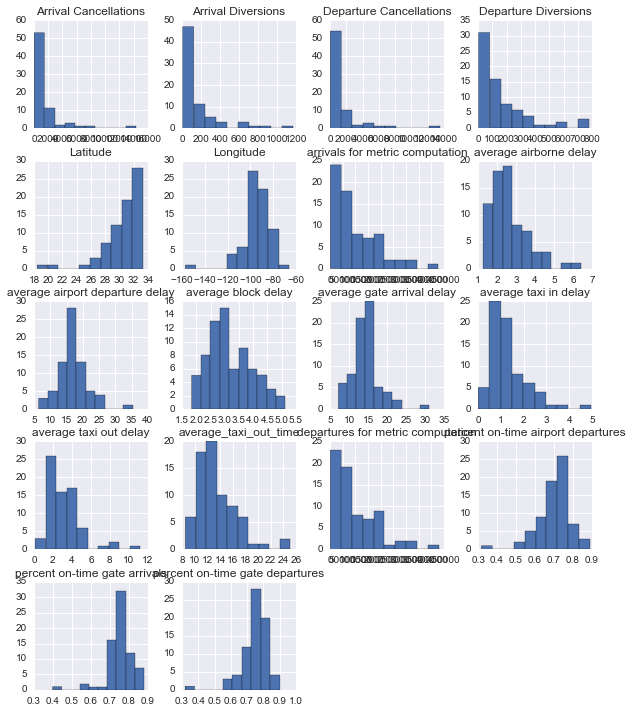

In [59]:
dfn.hist(figsize=(10,12))

#### 4.2 Find correlations in the data

In [123]:
xStand = StandardScaler().fit_transform(dfn)

In [124]:
dfs = pd.DataFrame(xStand)
dfs.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,-0.533103,-0.533988,-0.592961,-0.586254,-4.628737,2.353188,-0.750946,-0.749935,-0.096553,0.113082,-0.275454,-0.891975,-0.429185,-0.190500,-0.954392,-0.372621,-1.046279,0.066213
1,-0.635928,-0.586454,-0.547831,-0.627977,-3.595571,-5.142560,-0.320918,-0.367669,0.931664,1.171991,1.555607,-0.678633,-1.028456,-0.986675,1.467505,-0.938927,1.789291,-0.978319
2,2.320791,2.374620,3.440554,2.278760,-1.834490,1.187343,3.749426,3.750374,0.453795,0.097073,0.873251,1.198161,0.963566,-0.203588,0.082098,1.692034,0.012160,-0.549793
3,-0.447920,-0.458567,-0.468853,-0.308097,-1.686816,-0.225963,-0.440473,-0.441009,0.119655,0.380668,-0.415645,-0.545680,-0.623393,-0.277752,-0.420753,-0.301833,-0.419056,0.462600
4,-0.456488,-0.465126,-0.643733,-0.609434,-1.535797,-0.233523,-0.682848,-0.681925,0.520131,0.635676,0.080745,-0.236489,-0.334855,-0.539508,-0.328393,-0.455207,-0.732667,0.084961


In [126]:
# exporting correlation data to csv so that I can better work it in Excel
df_corr = dfs.corr()
df_corrdf = pd.DataFrame(df_corr)
df_corrdf
df_corrdf.to_csv('/Users/EKandTower/GA-DSI/projects/projects-weekly/project-07/\
assets/df_corrdf.csv')

In [99]:

df14b = pd.DataFrame(df14)

df14b = df14b.drop(['Year','Facility Type','Arrival Cancellations','Departure Diversions','Arrival Diversions',\
                  'Key','LocID','ALIAS','FAA REGION','Boundary Data Available','airport','year',\
                  'arrivals for metric computation','percent on-time gate departures',\
                  'percent on-time airport departures','percent on-time gate arrivals',\
                  'average_gate_departure_delay','average_taxi_out_time','average gate arrival delay'], axis=1)

df14b.head()

,AP_NAME,Departure Cancellations,COUNTY,CITY,STATE,AP Type,Latitude,Longitude,departures for metric computation,average taxi out delay,average airport departure delay,average airborne delay,average taxi in delay,average block delay
10,ABQ,315.0,0,546,11,0,18.439295,-66.002004,33292,2.41,15.99,1.73,1.02,2.40
21,ANC,111.0,235,328,6,1,21.152886,-157.096256,71099,1.33,12.34,4.09,0.54,4.57
32,ATL,5977.0,98,415,4,1,25.778333,-80.170278,428954,4.92,15.93,2.74,2.77,3.21
43,AUS,484.0,57,500,13,1,26.166194,-97.345889,60588,2.06,15.59,2.25,1.08,2.88
54,BDL,467.0,384,502,13,1,26.562843,-97.437759,39279,2.58,14.39,2.34,0.95,2.64


In [100]:
# filter locational information from df14b

dfn2 = pd.DataFrame(df14b)

dfn2 = dfn2.drop(['AP_NAME', 'COUNTY','CITY','STATE','AP Type','Latitude','Longitude'], axis=1)
                  
dfn2.head()

,Departure Cancellations,departures for metric computation,average taxi out delay,average airport departure delay,average airborne delay,average taxi in delay,average block delay
10,315.0,33292,2.41,15.99,1.73,1.02,2.40
21,111.0,71099,1.33,12.34,4.09,0.54,4.57
32,5977.0,428954,4.92,15.93,2.74,2.77,3.21
43,484.0,60588,2.06,15.59,2.25,1.08,2.88
54,467.0,39279,2.58,14.39,2.34,0.95,2.64


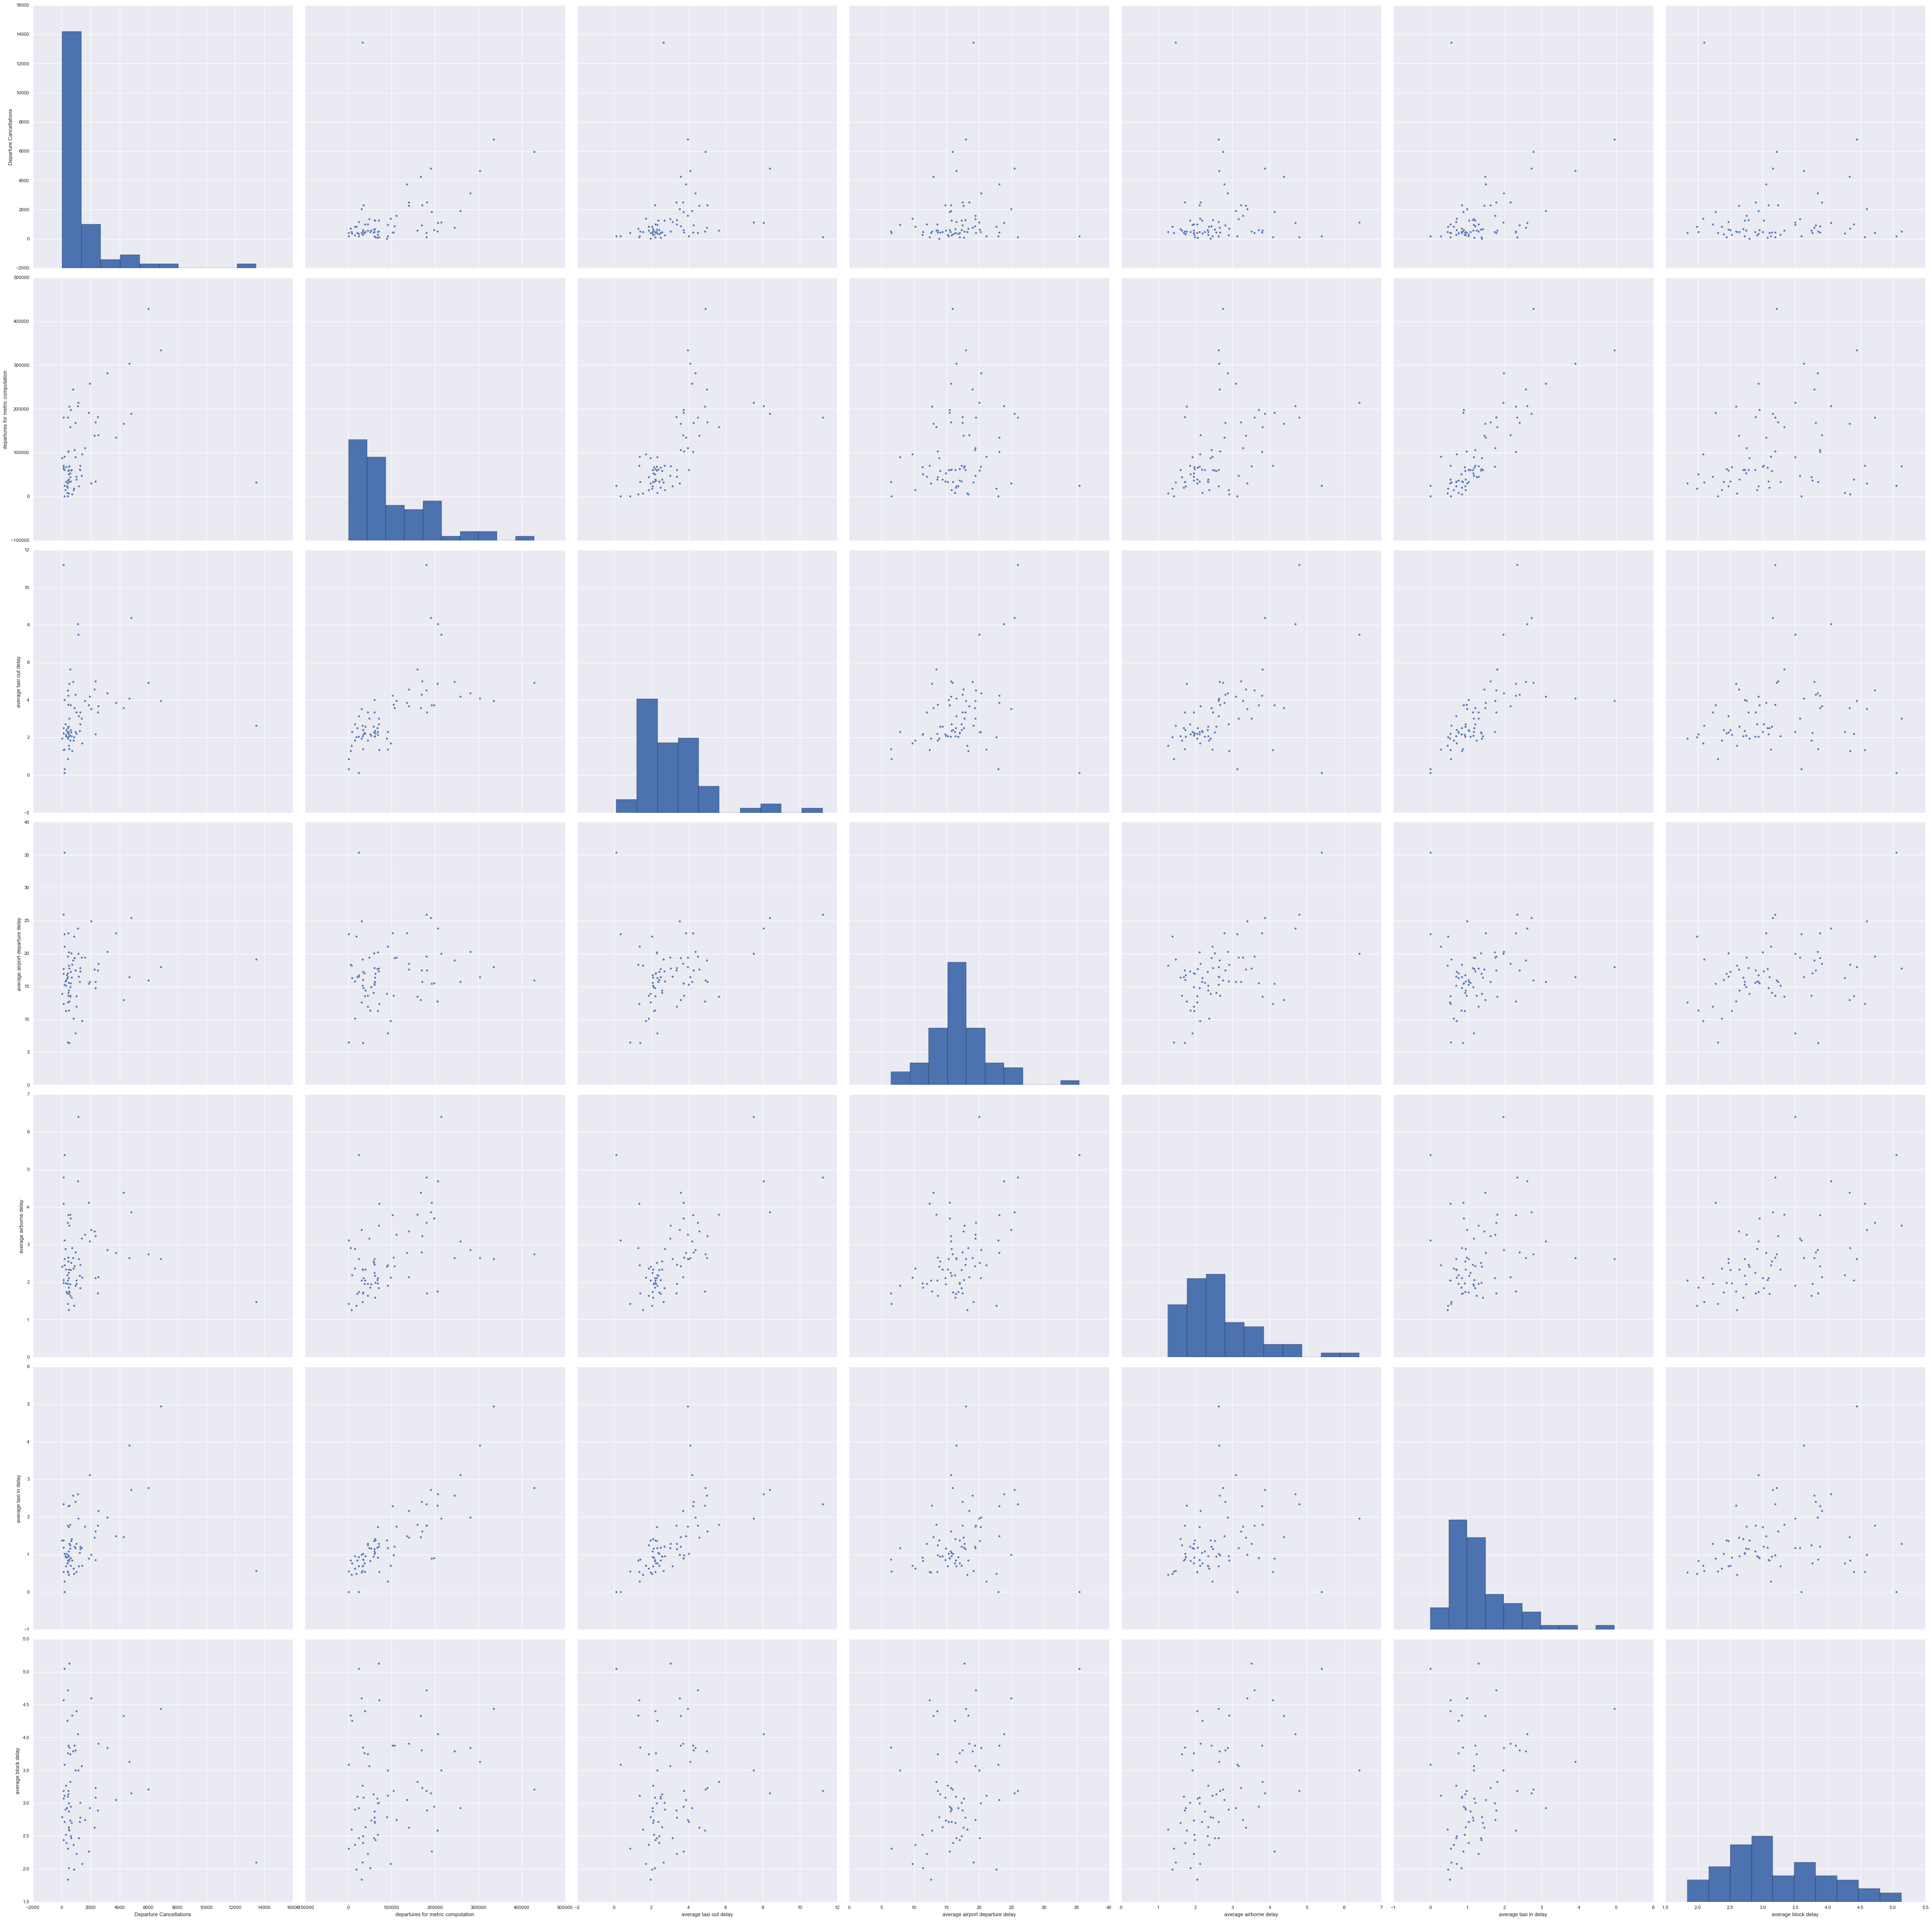

In [102]:
sns.pairplot(dfn2, kind="scatter")

#### 4.3 What is the value of understanding correlations before PCA? 

Answer: you should eliminate one side of highly correlated pairs

#### 4.4 Validate your findings using statistical analysis

#### 4.5 How can you improve your overall analysis? 

Answer: 

### Part 5: Perform a PCA

#### 5.1 Conduct the PCA

In [32]:
# change y to something

In [104]:
df14b.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72 entries, 10 to 804
Data columns (total 14 columns):
AP_NAME                              72 non-null object
Departure Cancellations              72 non-null float64
COUNTY                               72 non-null int64
CITY                                 72 non-null int64
STATE                                72 non-null int64
AP Type                              72 non-null int64
Latitude                             72 non-null float64
Longitude                            72 non-null float64
departures for metric computation    72 non-null int64
average taxi out delay               72 non-null float64
average airport departure delay      72 non-null float64
average airborne delay               72 non-null float64
average taxi in delay                72 non-null float64
average block delay                  72 non-null float64
dtypes: float64(8), int64(5), object(1)
memory usage: 8.4+ KB


In [105]:
x = df14b.ix[:,1:].values
y = df14b.ix[:,0].values

In [106]:
xStand = StandardScaler().fit_transform(x)

In [107]:
covMat = np.cov(xStand.T)
eigenValues, eigenVectors = np.linalg.eig(covMat)

In [108]:
print(eigenValues)
print(eigenVectors)

[ 3.21355058  1.91561954  1.43747537  1.32992091  1.15603484  0.10004425
  0.22205631  0.31235345  0.86548365  0.80913269  0.73455666  0.54043166
  0.54643868]
[[ 0.23923323 -0.26697312  0.18179296  0.05540677  0.33664976  0.06991346
   0.14169599 -0.13385954 -0.37836836 -0.18197036  0.63310796 -0.26287136
   0.18153313]
 [-0.09916252  0.01624187 -0.52089986 -0.3074634   0.13643409 -0.04327569
   0.0522487   0.0052482  -0.08223915  0.59633606  0.3267006  -0.09291176
  -0.35077376]
 [-0.05377649 -0.23591671 -0.32301947 -0.44938843 -0.45038022 -0.07626539
  -0.11866711 -0.00761958 -0.15590921 -0.14411411  0.12964439  0.22885293
   0.54598834]
 [ 0.0789186  -0.02926669 -0.37139571  0.46537728  0.0161543  -0.02159438
  -0.01751515 -0.15704252 -0.62661606  0.14519107 -0.41508801 -0.06721364
   0.14887667]
 [-0.1095324   0.34815588  0.17563089 -0.40695569 -0.0182069   0.11419739
   0.11285137 -0.1051324  -0.55763257 -0.3071556  -0.07926291  0.2549088
  -0.39574039]
 [-0.0285895   0.33072532 

In [109]:
eigenPairs = [(np.abs(eigenValues[i]), eigenVectors[:,i]) for i in range(len(eigenValues))]
eigenPairs.sort()
eigenPairs.reverse()
for i in eigenPairs:
    print(i[0])

3.21355058168
1.9156195422
1.43747537016
1.32992091202
1.15603484227
0.865483652288
0.809132690208
0.73455665909
0.546438679698
0.540431662653
0.312353445072
0.222056308382
0.100044245838


In [110]:
totalEigen = sum(eigenValues)
varExpl = [(i / totalEigen)*100 for i in sorted(eigenValues, reverse=True)]
cumulvarExpl = np.cumsum(varExpl)

In [111]:
print(cumulvarExpl)

[ 24.37629181  38.90716654  49.81109296  59.89916825  68.66823596
  75.23333632  81.37098814  86.9429457   91.08793996  95.18736817
  97.55671588  99.24111737 100.        ]


In [114]:
airports_pca = PCA(n_components=2)
airports_pca.fit(xStand)
X = airports_pca.transform(xStand)

airports_pca.components_
# components_.X


array([[ 0.23923323, -0.09916252, -0.05377649,  0.0789186 , -0.1095324 ,
        -0.0285895 , -0.0526412 ,  0.47120275,  0.44965954,  0.27217662,
         0.37167554,  0.45543554,  0.2536894 ],
       [-0.26697312,  0.01624187, -0.23591671, -0.02926669,  0.34815588,
         0.33072532, -0.41827647, -0.18780036, -0.07653845,  0.22286458,
         0.34985138, -0.22296943,  0.4511034 ]])

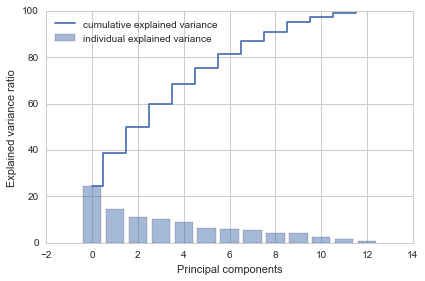

In [115]:
from matplotlib import pyplot as plt
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 4))

    plt.bar(range(len(cumulvarExpl)), varExpl, alpha=0.5, align='center',
            label='individual explained variance')
    plt.step(range(len(cumulvarExpl)), cumulvarExpl, where='mid',
             label='cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.tight_layout()

### Part 6: Additional Analysis
Include any other models you'd like to run here. These can include regressions, classifications, or clusters. 

### Part 7: Write an analysis plan of your findings 

Create a writeup on the interpretation of findings including an executive summary with conclusions and next steps. Put it on your blog, and include the link here.

Which operational features are most correlated with delays?

What should the airport's next steps be?

### Bonus: Copy your Database to AWS 

Make sure to properly document all of the features of your dataset

### Bonus: Create a 3-Dimensional Plot of your new dataset with PCA applied